# Finding potential fragment merges with the Fragment Network

This notebook illustrates how to use the Fragment Network to find purchasable molecules that
combine parts of two fragments.

For information about the Fragment Network see:
* [doi:10.1021/acs.jmedchem.7b00809](https://pubs.acs.org/doi/10.1021/acs.jmedchem.7b00809)
* https://fragnet.informaticsmatters.com/

The assumption is that you have 2 fragment screening hits that are partly overlapping in space.
You want to identify purchasable molecules that might be *best of both worlds* in forming interactions
from both fragments.

We use the term "synthon" to mean a fragment of a molecule in the context of the Fragment Network.
We use this term rather than fragment to avoid confusion with the use of that name in fragment screening. 

The approach is to:
* Identify the synthons of fragment B that you want to graft onto fragment A 
* Start from fragment A and optionally add one synthon of any type (mols1)
* For those molecules optionally remove one synthon(mols2)
* For each synthon from fragment B add it to each of mols2 (mols3)

Where we state remove a synthon we mean find molecules in the Fragment Network that is a direct child of the source molecule.
Where we state add a synthon we mean find molecules in the Fragment Network that is a direct parent of the source molecule.

The result is a set of molecules derived from fragment A, possibly missing one synthon, having one synthon from fragment B added and possibly having one extra synthon of any type added.

One a small subset of these will be able to take up favourable conformations that are compatible with forming the relevent interactions formed by fragments A and B. This has to be checked using subsequent 3D techniques. 

## Usage

To use this you must have a Fragment Network Neo4j database running on your machine.

Typically do this with one of our [test containers](https://github.com/InformaticsMatters/docker-fragnet-test)
of by using `kubect port-forward ...` to access a real database running in K8S. 

In [48]:
from neo4j import GraphDatabase
from rdkit import Chem
from rdkit.Chem import Draw

In [49]:
# prompt for the database password
import getpass
try:
    password
except NameError:
    password = getpass.getpass()

In [50]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", password))

In [51]:
# simple example of a finding a molecule using its SMILES
def find_molecule_node(tx, smiles):
    for record in tx.run('MATCH (m:F2 {smiles: $smiles}) RETURN m', smiles=smiles):
        node = record['m']
        return node

In [52]:
def mols_from_smiles(smiles):
    mols = [Chem.MolFromSmiles(s) for s in smiles ]
    return mols

## Parameters

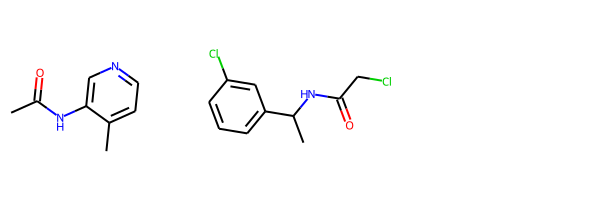

In [53]:
x0107 = 'CC(=O)Nc1cnccc1C'
x0397 = 'Cc1cc(CN(C)C(=O)NC2CC2)no1'
x0434 = 'O=C(Nc1ccccc1)Nc1cccnc1'
x0874 = 'NC(=O)[C@H]1CCC[C@H]1c1ccsc1' # not present
x1093 = 'CN1CCN(C(=O)Cc2c[nH]c3ncccc23)CC1'
x1382 = 'CC(NC(=O)CCl)c1cccc(Cl)c1'
x2646 = 'Cc1ccncc1NC(=O)Cc1cccc(Cl)c1' # TRY-UNI-714a760b-6

fragment_a = x0107
fragment_b = x1382

mol_a = Chem.MolFromSmiles(fragment_a)
mol_b = Chem.MolFromSmiles(fragment_b)

Draw.MolsToGridImage([mol_a, mol_b])

## Verify that those fragments are in the fragment network database

In [54]:
with driver.session() as session:
    mol = session.read_transaction(find_molecule_node, fragment_a)
    print(mol)

<Node id=75937121 labels=frozenset({'F2', 'V_REAL', 'CanSmi', 'V_MP', 'Mol'}) properties={'osmiles': 'CC(O)NC1CCCCC1C', 'chac': 6, 'hac': 11, 'smiles': 'CC(=O)Nc1cnccc1C', 'cmpd_ids': ['REAL:Z1129283193', 'MOLPORT:003-985-997']}>


In [55]:
with driver.session() as session:
    mol = session.read_transaction(find_molecule_node, fragment_b)
    print(mol)

<Node id=97717513 labels=frozenset({'F2', 'V_MP', 'Mol', 'CanSmi'}) properties={'osmiles': 'CC(NC(O)CCl)C1CCCC(Cl)C1', 'chac': 6, 'hac': 14, 'smiles': 'CC(NC(=O)CCl)c1cccc(Cl)c1', 'cmpd_ids': ['MOLPORT:002-466-937']}>


## Child synthons
Methods to find all child synthons of a molecule. The edges have a 'label' property that looks like this:

`RING|[Xe]c1nncs1|[103Xe]C1CCCC1|RING|O=C(Cc1c[nH]c2ncccc12)N1CCN(C[Xe])CC1|OC(CC1CCC2CCCCC12)C1CCC(C[103Xe])CC1`

This has six tokens.
The second token describes what was added/removed.
The fith token describes what it was added/removed to/from.
Both use a Xe atom to mark the attachment site.
Hence those two tokens can be considered potential *synthons*.
They have to be filtered to remove molecules with 2 components and those with 2 attachements sites as those are
not able to make simple adducts.

In [56]:
def add_required_synthons(labels, synthon):
    """Only add synthons with a single attachment point and a single component"""
    if '.' not in synthon and synthon.count('[Xe]') == 1:
        labels.add(synthon)

def find_synthons(tx, smiles):
    """Query for all child fragments (recursive).
    Extract the label property of each edge and collect a set of SMILES that match our needs.
    """
    labels = set()
    for record in tx.run('MATCH (fa:F2 {smiles: $smiles})-[e:FRAG*]->(f:F2) RETURN e', smiles=smiles):
        edges = record['e']
        for edge in edges:
            s = edge['label']
            tokens = s.split('|')
            add_required_synthons(labels, tokens[1])
            add_required_synthons(labels, tokens[4])
    return list(labels)

Found 5 synthons
CC(NC(=O)CCl)c1cccc([Xe])c1
[Xe]c1ccccc1
Cl[Xe]
Clc1cccc([Xe])c1
CC([Xe])NC(=O)CCl


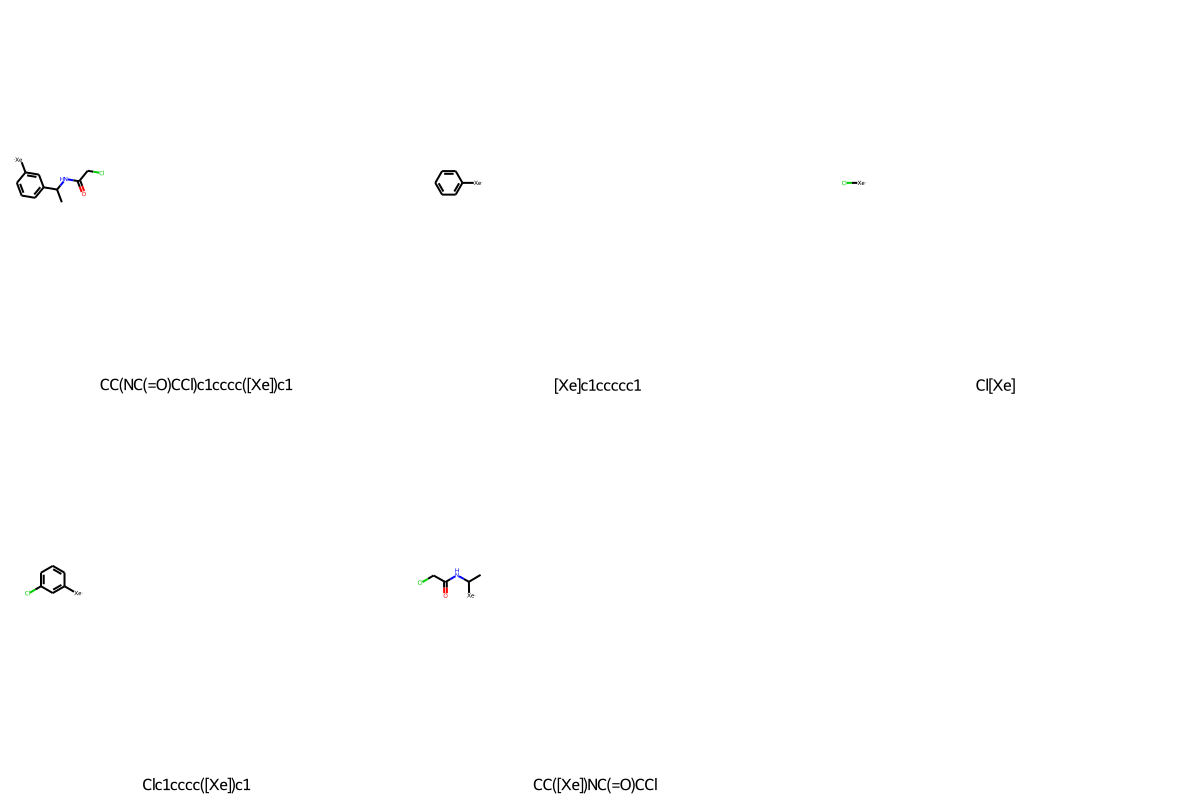

In [57]:
# Generate synthons or fragment B
with driver.session() as session:
    synthons = session.read_transaction(find_synthons, fragment_b)
    print('Found', len(synthons), 'synthons')
    for s in synthons:
        print(s)

Draw.MolsToGridImage(mols_from_smiles(synthons), legends=synthons, subImgSize=(400, 400))

## Expand fragment A

In [58]:
def find_expansions(tx, smiles, synthon):
    """Expand the molecules with this SMILES using this synthon"""
    expansions = set()
    for record in tx.run("MATCH (fa:F2 {smiles: $smiles})"
                         "<-[:FRAG*0..1]-(:F2)"
                         "-[:FRAG*0..1]->(:F2)"
                         "<-[e:FRAG]-(c:Mol) "
                         "WHERE split(e.label, '|')[1] = $synthon RETURN c", 
                         smiles=smiles, synthon=synthon):
        node = record['c']
        expansions.add(node['smiles'])
    return expansions

In [59]:
# do the expansions

data = []
synthon_mols = []
with driver.session() as session:
    count = 0
    synthon_no = 0
    expanded_synthons = 0
    # for each synthon
    for synthon in synthons:
        synthon_mol = Chem.MolFromSmiles(synthon)
        synthon_mols.append(synthon_mol)
        synthon_data = []
        data.append(synthon_data)
        # do the expansion of fragment_a with that synthon
        print('Running synthon', synthon_no, synthon)
        expansions = session.read_transaction(find_expansions, fragment_a, synthon)
        print('Found', len(expansions), 'expansions')
        count += len(expansions)
        if (len(expansions)):
            expanded_synthons += 1
        for e in expansions:
            #print(e)
            synthon_data.append(e)
        synthon_no += 1
        
    print(count, 'total expansions from', expanded_synthons, 'out of', len(synthons), 'synthons')

Running synthon 0 CC(NC(=O)CCl)c1cccc([Xe])c1
Found 0 expansions
Running synthon 1 [Xe]c1ccccc1
Found 97 expansions
Running synthon 2 Cl[Xe]
Found 85 expansions
Running synthon 3 Clc1cccc([Xe])c1
Found 0 expansions
Running synthon 4 CC([Xe])NC(=O)CCl
Found 0 expansions
182 total expansions from 2 out of 5 synthons


In [60]:
synthon_to_print = 2

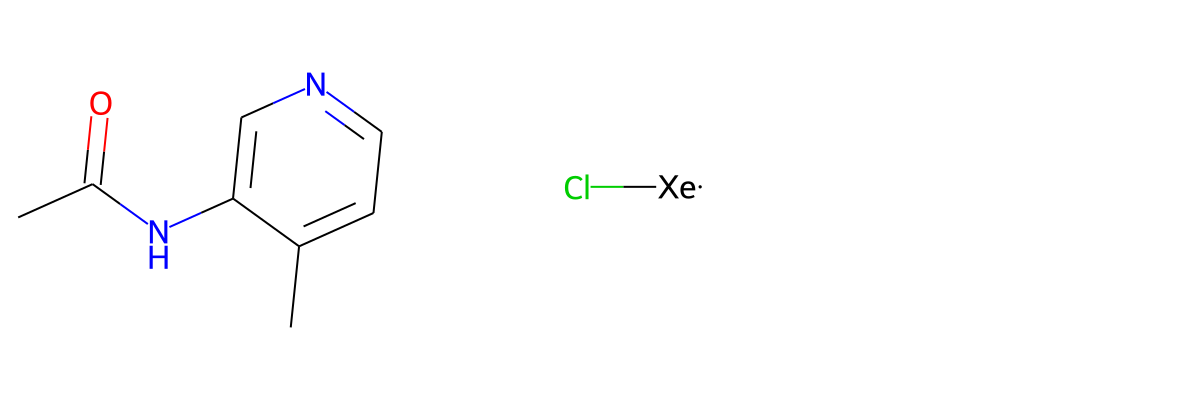

In [61]:
Draw.MolsToGridImage([mol_a, synthon_mols[synthon_to_print]], molsPerRow=3, subImgSize=(400, 400))

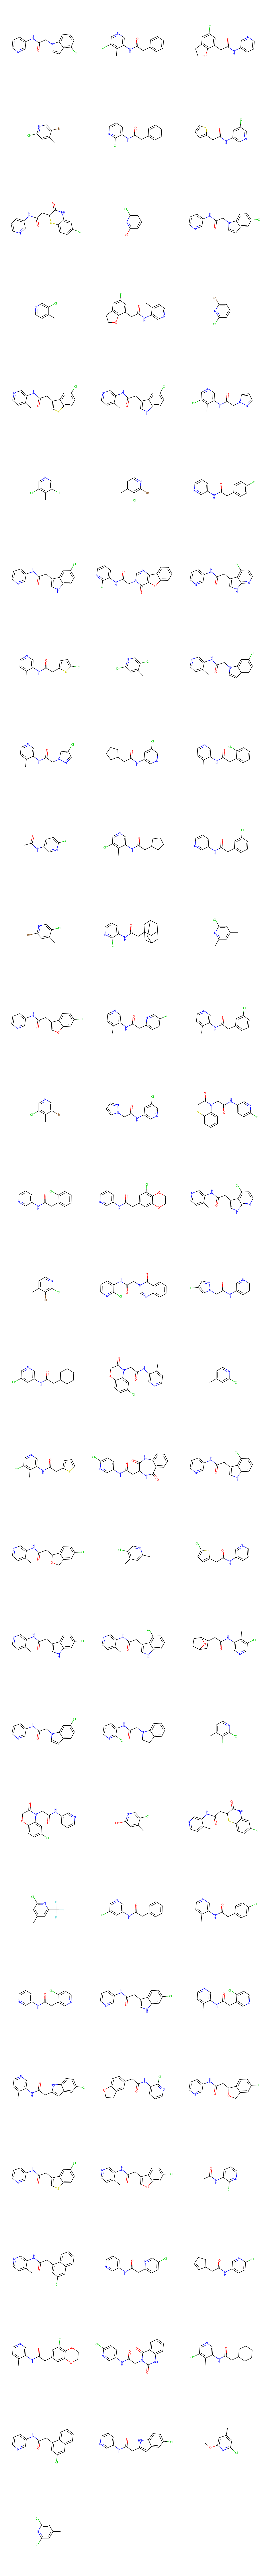

In [62]:
Draw.MolsToGridImage(mols_from_smiles(data[synthon_to_print]), molsPerRow=3, subImgSize=(400, 400), maxMols=120)

In [63]:
for s in data[synthon_to_print]:
    print(s)

O=C(Cn1ccc2c(Cl)cccc21)Nc1cccnc1
Cc1c(Cl)cncc1NC(=O)Cc1ccccc1
O=C(Cc1cc(Cl)cc2c1OCC2)Nc1cccnc1
Cc1cc(Cl)ncc1Br
O=C(Cc1ccccc1)Nc1cccnc1Cl
O=C(Cc1cccs1)Nc1cncc(Cl)c1
O=C(CC1Sc2ccc(Cl)cc2NC1=O)Nc1cccnc1
Cc1cc(O)nc(Cl)c1
O=C(Cn1ccc2cc(Cl)ccc21)Nc1cccnc1
Cc1ccncc1Cl
Cc1ccncc1NC(=O)Cc1cc(Cl)cc2c1OCC2
Cc1cc(Cl)nc(Br)c1
Cc1ccncc1NC(=O)Cc1csc2ccc(Cl)cc12
Cc1ccncc1NC(=O)Cc1c[nH]c2ccc(Cl)cc12
Cc1c(Cl)cncc1NC(=O)Cn1cccn1
Cc1c(Cl)cncc1Cl
Cc1ccnc(Br)c1Cl
O=C(Cc1ccc(Cl)cc1)Nc1cccnc1
O=C(Cc1c[nH]c2ccc(Cl)cc12)Nc1cccnc1
O=C(Cn1cnc2c(oc3ccccc32)c1=O)Nc1cccnc1Cl
O=C(Cc1c[nH]c2nccc(Cl)c12)Nc1cccnc1
Cc1ccncc1NC(=O)Cc1ccc(Cl)s1
Cc1cc(Cl)ncc1Cl
Cc1ccncc1NC(=O)Cn1ccc2ccc(Cl)cc21
Cc1ccncc1NC(=O)Cn1cc(Cl)cn1
O=C(CC1CCCC1)Nc1cncc(Cl)c1
Cc1ccncc1NC(=O)Cc1ccccc1Cl
CC(=O)Nc1ccc(Cl)nc1
Cc1c(Cl)cncc1NC(=O)CC1CCCC1
O=C(Cc1cccc(Cl)c1)Nc1cccnc1
Cc1cc(Br)ncc1Cl
O=C(CC12CC3CC(CC(C3)C1)C2)Nc1cccnc1Cl
Cc1cc(C)nc(Cl)c1
O=C(Cc1coc2cc(Cl)ccc12)Nc1cccnc1
Cc1ccncc1NC(=O)Cc1ccc(Cl)cn1
Cc1ccncc1NC(=O)Cc1cccc(Cl)c1
Cc1c(Cl)cncc1Br


In [64]:
#driver.close()